# Liver Model Construction: Huge Core Model

In [52]:
import os
import re
import warnings
from cobra.io import *
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa, qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
# adding Folder_2 to the system path
sys.path.insert(0, "c:\\Users\\sicil\\LiverModel")
from cobra_dict import *
import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
import sys
# from minspan import minspan,nnz

MASSpy version: 0.1.6


In [53]:
mass.__version__
cobra.__version__

'0.22.1'

In [54]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")


### Getting reactions and metabolite data from RECON 3D

In [55]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"big_core_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')


### Loading cobra model

In [56]:
# Initiate empty model
trial= cobra.Model()

In [57]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    trial.add_metabolites(met)

# Loading reaction data as JSON file to maintain data types as dictionaries 
rxn_json = os.path.join(data_dir,"big_core_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)
    

In [58]:
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [59]:
trial.metabolites.h_c.charge= 1
trial.metabolites.h_m.charge= 1
trial.metabolites.h_i.charge= 1
trial.metabolites.pi_c.charge= -2
trial.metabolites.pi_m.charge= -2

In [60]:
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

CSm {}
ACONTm {}
ICDHxm {}
AKGDm {}
SUCOASm {}
SUCD1m {}
FUMm {}
MDHm {}
NADH2_u10mi {}
FADH2ETC {}
CYOR_u10mi {}
CYOOm2i {}
ATPS4mi {}
Htmi {}
HEX1 {}
PGI {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PYK {}
ADK1 {}
PDHm {}
LDH_L {}
G6PDH2r {}
PGL {}
GND {}
RPI {}
RPE {}
TKT1 {}
TKT2 {}
TALA {}
PCm {}
PEPCKm {}
FBP {}
G6PPer {'charge': 2.0}
G6Pter {}
GLCter {}
MALtm {}
MDH {}
PEPCK_re {}
PGMT {}
GALUi {}
GLGNS1 {}
GLBRAN {}
GLPASE1 {}
GLDBRAN {}
GLPASE2 {}
GGNG {}
ACACT1m {}
HMGCOASm {}
HMGLm {}
ADCim {}
BDHm {}
OCOAT1m {}
NDPK1 {}
NDPK1m {}
NDPK2 {}
HCO3Em {}
ATPtm {}
AKGMALtm {}
ASPTA {}
ASPTAm {}
CITtam {}
CITL {}
ME2 {}
ACS {}
ARGN {}
OCBTm {}
ARGSS {}
ARGSL {}
CBPSam {}
NH4tm {}
GDHm {}
GLNS {}
GLUN {}
ALATA_L {}
CYSO {}
3SALATAi {}
3SPYRSP {}
PGCD {}
PSERT {}
PSP_L {}
GHMT2r {}
ASNS1 {}
GLYtm {}
MLTHFtm {}
THFtm {}
KHK {}
FBA2 {}
TRIOK {}
ALCD19y {}
GLYK {}
2AMACHYD {}
SERHL {}
ALCD2x {}
ACALDtm {}
ALDD2xm {}
ACSm {}
Htm {}
O2tm {}
H2Otr {}
H2Otm {}
PItm {}
PItr {'charge'

In [61]:
trial.objective = 'ATPS4mi'
flux= trial.optimize()
flux


,fluxes,reduced_costs
CSm,2.0,0.000000
ACONTm,2.0,0.000000
ICDHxm,2.0,0.000000
AKGDm,2.0,0.000000
SUCOASm,28.0,0.000000
...,...,...
GTHPi,0.0,0.000000
GTHOr,0.0,-4.666667
NADPHM,0.0,-4.666667
EX_r5p_c,0.0,-46.666667


In [62]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [63]:
#Compare Results
excel_ic = os.path.join(data_dir,"Fluxes_Data.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
fluxes = load_data(
    filepath=excel_ic,
    sheet_name="Model_data"
    )
# ic_info_all.reset_index(level='ID', col_level=1, inplace=True)

fluxes

,val
met,
glygn2_c,-0.015600
ala__L_c,-0.096667
nh4_c,-0.090533
gly_c,-0.015827
gln__L_c,-0.034667
ser__L_c,-0.009720
glc__D_c,-0.037452


In [64]:
# rows_of_interest = ['glygn2_c', 'glc__D_c', 'ala__L_c','nh4_c','ser__L_c']
# fluxes= fluxes.loc[rows_of_interest]
# fluxes = fluxes
fluxes

,val
met,
glygn2_c,-0.015600
ala__L_c,-0.096667
nh4_c,-0.090533
gly_c,-0.015827
gln__L_c,-0.034667
ser__L_c,-0.009720
glc__D_c,-0.037452


In [65]:
print("Setting Experimental fluxes\n------------------")

for reaction in trial.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    if 'EX_' in reaction.id:
        for met in reaction.metabolites:
            # print(met)
            if met.id in fluxes.index:
                mid=met.id
                # print(mid)
                flux = fluxes.loc[mid,'val']
                # print(flux)
            #     row = [mid,ic_value]
            #     # column = [ic_value]
            #     # conc_df.append(row)
                reaction.lower_bound =  flux       
                reaction.upper_bound =  -flux     #mol/L*hr = M/hr
                
                print(reaction.id, reaction.lower_bound, reaction.upper_bound)       
# for metabolite, ic_value in liver.initial_conditions.items():
#     print("{0}: {1}".format(metabolite, ic_value))

Setting Experimental fluxes
------------------
EX_glc__D_c -0.0374517 0.0374517
EX_gln__L_c -0.0346666666666667 0.0346666666666667
EX_ser__L_c -0.00972 0.00972
EX_gly_c -0.015826666666666666 0.015826666666666666
EX_glygn2_c -0.015600000000000001 0.015600000000000001
EX_ala__L_c -0.09666666666666666 0.09666666666666666
EX_nh4_c -0.09053333333333334 0.09053333333333334


In [66]:
for r in trial.reactions:
    if 'EX_' in r.id:
    
        print(r.id, r.lower_bound, r.upper_bound)

EX_h_c -1000.0 1000.0
EX_pyr_c 0.0 1000.0
EX_h2o_c -1000.0 1000.0
EX_pi_c -1000.0 1000.0
EX_glc__D_c -0.0374517 0.0374517
EX_lac__L_c 0.0 1000.0
EX_co2_c 0.0 1000.0
EX_o2_c -1000.0 1000.0
EX_octa_prod_c 0.0 1000.0
EX_octa_cons_c 0.0 0.0
EX_urea_c 0.0 1000.0
EX_gln__L_c -0.0346666666666667 0.0346666666666667
EX_acetone_c 0.0 1000.0
EX_bhb_c 0.0 1000.0
EX_glu__L_c 0.0 1000.0
EX_ser__L_c -0.00972 0.00972
EX_cys__L_c 0.0 1000.0
EX_gly_c -0.015826666666666666 0.015826666666666666
EX_glygn2_c -0.015600000000000001 0.015600000000000001
EX_Tyr_ggn_c -1000.0 1000.0
EX_ala__L_c -0.09666666666666666 0.09666666666666666
EX_nh4_c -0.09053333333333334 0.09053333333333334
EX_so3_c 0.0 1000.0
EX_etoh_c 0.0 1000.0
EX_glyc_3octa_c 0.0 1000.0
EX_fru_c 0.0 1000.0
EX_r5p_c 0.0 1000.0
EX_o2s_c -1000.0 1000.0


In [67]:
# futile_cycle_1 = trial.problem.Constraint(
#     trial.reactions.PFK.flux_expression - trial.reactions.FBP.flux_expression,
#     lb=-60,
#     ub=60)
# trial.add_cons_vars(futile_cycle_1)


# futile_cycle_2 = trial.problem.Constraint(
#     trial.reactions.HEX1.flux_expression - trial.reactions.G6PPer.flux_expression,
#     lb=-1000,
#     ub=1000)
# trial.add_cons_vars(futile_cycle_2)

# # try doubling the two above because of the 2:1 ratio
# futile_cycle_3 = trial.problem.Constraint(
#     trial.reactions.PYK.flux_expression - trial.reactions.PCm.flux_expression,
#     lb=-20,
#     ub=20)
# trial.add_cons_vars(futile_cycle_3)


# constraint = trial.problem.Constraint(-
#     trial.reactions.EX_glc__D_c.flux_expression 
#     - trial.reactions.EX_glc__D_c.flux_expression,
#     lb=-20,
#     ub=20)
# trial.add_cons_vars(constraint)

In [68]:
dual_objective = trial.problem.Objective(
    -trial.reactions.EX_glygn2_c.flux_expression-
    trial.reactions.EX_glc__D_c.flux_expression,
    direction='max')
trial.objective = dual_objective
solution = trial.optimize(objective_sense='maximise')
# try adding ratios of glycogen to glucose in objective function
# try making the flux reactons of PGI, GLUT2, 
solution

,fluxes,reduced_costs
CSm,0.418103,0.0
ACONTm,0.418103,0.0
ICDHxm,0.418103,0.0
AKGDm,0.418103,0.0
SUCOASm,5.853448,0.0
...,...,...
GTHPi,0.000000,0.0
GTHOr,0.000000,0.0
NADPHM,0.000000,0.0
EX_r5p_c,0.000000,-0.0


In [69]:
# #Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in solution.fluxes.items()}


#view all the reactions that we need build
escher_builder = escher.Builder(
    # model=trial,
    map_json=os.path.join(
        maps_dir,"core_map_v23.json")
        # ,highlight_missing=True
    , reaction_data=initial_flux_data
    )

# Display map in notebook
escher_builder

Builder(reaction_data={'CSm': 0.4181034, 'ACONTm': 0.4181034, 'ICDHxm': 0.4181034, 'AKGDm': 0.4181034, 'SUCOAS…

In [70]:
from cobra.util.solver import linear_reaction_coefficients
from cobra.io import json

In [71]:
linear_reaction_coefficients(trial)

{<Reaction EX_glc__D_c at 0x1d0b46684f0>: -1.0,
 <Reaction EX_glygn2_c at 0x1d0b465ffd0>: -1.0}

In [72]:
trial.reactions.PGI

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x01d0b3e833d0
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


## Solution Space (sampling)




sampling 4 different flux states and seeing overlap in distributions

## FVA analysis

In [73]:
from cobra.flux_analysis import flux_variability_analysis

In [74]:
dual_objective = trial.problem.Objective(
    -trial.reactions.EX_glygn2_c.flux_expression-
    trial.reactions.EX_glc__D_c.flux_expression,
    direction='min')
trial.objective = dual_objective
solution = trial.optimize(objective_sense='maximise')
# try adding ratios of glycogen to glucose in objective function
# try making the flux reactons of PGI, GLUT2, 
solution

,fluxes,reduced_costs
CSm,0.021592,0.000000e+00
ACONTm,0.021592,0.000000e+00
ICDHxm,0.021592,-8.673617e-19
AKGDm,0.056259,-8.673617e-19
SUCOASm,-0.056259,4.770490e-18
...,...,...
GTHPi,0.000000,0.000000e+00
GTHOr,0.000000,1.464981e-02
NADPHM,0.000000,1.464981e-02
EX_r5p_c,0.000000,1.464981e-01


In [75]:
fva = flux_variability_analysis(trial, fraction_of_optimum= 0.1)
fva = fva.T
fva

combined =trial.copy()
data_1 = cobra.sampling.sample(combined, 5000, method = "optgp", processes = 5)

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpsegpkdfr.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp0ogpavol.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros


In [76]:
dual_objective = trial.problem.Objective(
    -trial.reactions.EX_glygn2_c.flux_expression+
    trial.reactions.EX_glc__D_c.flux_expression,
    direction='min')
trial.objective = dual_objective
solution = trial.optimize(objective_sense='maximise')

In [77]:
fva_2 = flux_variability_analysis(trial, fraction_of_optimum= 0.1)
fva_2 = fva_2.T
fva_2

,CSm,ACONTm,ICDHxm,AKGDm,SUCOASm,SUCD1m,FUMm,MDHm,NADH2_u10mi,FADH2ETC,...,EX_nh4_c,EX_so3_c,EX_etoh_c,EX_glyc_3octa_c,EX_fru_c,GTHPi,GTHOr,NADPHM,EX_r5p_c,EX_o2s_c
minimum,0.000000,0.000000,0.000000,0.000000,-0.593823,0.000000,0.00000,-0.838470,0.000000,0.000000,...,-0.090533,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
maximum,0.559157,0.559157,0.559157,0.593823,7.944041,0.593823,0.72695,5.220864,2.855397,0.593823,...,0.090533,0.0,0.0,0.0,0.0,0.0,0.0,3.167864,0.316786,0.0


In [78]:
trial.reactions.PGI

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x01d0b3e833d0
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [79]:
combined =trial.copy()
data_2 = cobra.sampling.sample(combined, 5000, method = "optgp", processes = 5)


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpxox4o3oe.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpuri46d_d.lp
Reading time = 0.02 seconds
: 183 rows, 384 columns, 1448 nonzeros


In [80]:
dual_objective = trial.problem.Objective(
    +trial.reactions.EX_glygn2_c.flux_expression-
    trial.reactions.EX_glc__D_c.flux_expression,
    direction='max')
trial.objective = dual_objective
solution = trial.optimize(objective_sense='maximise')

In [81]:
fva_3 = flux_variability_analysis(trial, fraction_of_optimum= 0.1)
fva_3 = fva_3.T
fva_3

,CSm,ACONTm,ICDHxm,AKGDm,SUCOASm,SUCD1m,FUMm,MDHm,NADH2_u10mi,FADH2ETC,...,EX_nh4_c,EX_so3_c,EX_etoh_c,EX_glyc_3octa_c,EX_fru_c,GTHPi,GTHOr,NADPHM,EX_r5p_c,EX_o2s_c
minimum,0.000000,0.000000,0.000000,0.000000,-0.593823,0.000000,0.00000,-0.838470,0.000000,0.000000,...,-0.090533,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
maximum,0.559157,0.559157,0.559157,0.593823,7.944041,0.593823,0.72695,5.220864,2.855397,0.593823,...,0.090533,0.0,0.0,0.0,0.0,0.0,0.0,3.167864,0.316786,0.0


In [82]:
combined =trial.copy()
data_3 = cobra.sampling.sample(combined, 5000, method = "optgp", processes = 5)


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmptww9e6lk.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpjh2m_qdy.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros


In [83]:
trial.reactions.PGI

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x01d0b3e833d0
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [84]:
dual_objective = trial.problem.Objective(
    +trial.reactions.EX_glygn2_c.flux_expression+
    trial.reactions.EX_glc__D_c.flux_expression,
    direction='min')
trial.objective = dual_objective
solution = trial.optimize(objective_sense='maximise')

In [85]:
fva_4 = flux_variability_analysis(trial, fraction_of_optimum= 0.1)
fva_4 = fva_4.T
fva_4.EX_glc__D_c

minimum   -0.037452
maximum    0.010295
Name: EX_glc__D_c, dtype: float64

In [86]:
fva.PGMT

minimum   -2.372472
maximum    0.046800
Name: PGMT, dtype: float64

In [87]:
trial.reactions.PGMT

Reaction identifier,PGMT
Name,Phosphoglucomutase
Memory address,0x01d0b718cf70
Stoichiometry,g1p_c <=> g6p_c D-Glucose 1-phosphate <=> D-Glucose 6-phosphate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [88]:
combined =trial.copy()
data_4 = cobra.sampling.sample(combined, 5000, method = "optgp", processes = 5)


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpbxlkpb6z.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp2u7pcf7a.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros


In [89]:
trial.reactions.PGI

Reaction identifier,PGI
Name,Glucose-6-phosphate isomerase
Memory address,0x01d0b3e833d0
Stoichiometry,g6p_c <=> f6p_c D-Glucose 6-phosphate <=> D-Fructose 6-phosphate
GPR,
Lower bound,-1000.0
Upper bound,1000.0


Text(0.5, 0, 'EX_glc__D_c flux')

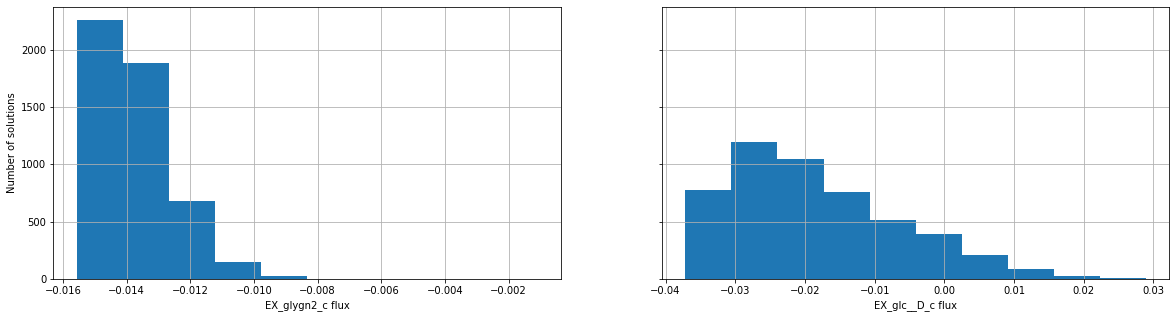

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
ax = axes[0]
data_1['EX_glygn2_c'].hist(ax=ax)
ax.set_xlabel('EX_glygn2_c flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = data_1['EX_glc__D_c'].hist(ax=ax)
ax.set_xlabel('EX_glc__D_c flux')

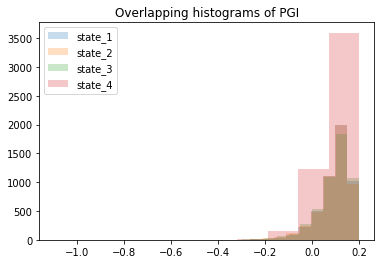

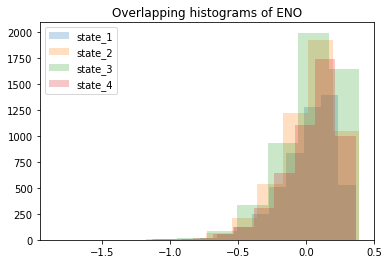

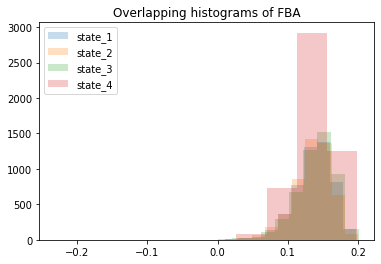

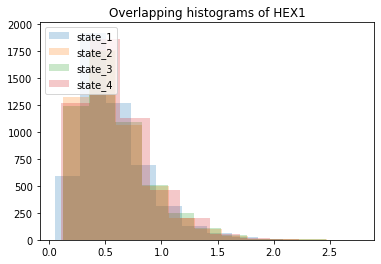

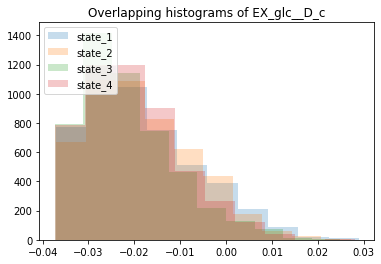

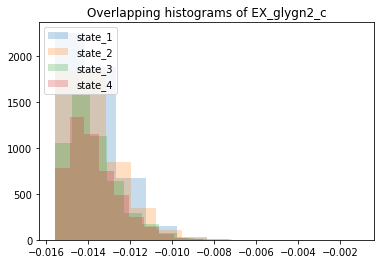

In [91]:
list_rxn =['PGI', 'ENO', "FBA", "HEX1", "EX_glc__D_c", "EX_glygn2_c"]
# #  GAPDH, ENO, FBA, PGI, PGMT
for i in list_rxn:
    plt.hist(data_1[i], 
         alpha=0.25, # the transaparency parameter
         label='state_1')
#     x_position = mean_flux.loc[i, "mean"]
  
    plt.hist(data_2[i], 
            alpha=0.25, # the transaparency parameter
            label='state_2')
    # x_position = mean_flux.loc[i, "mean"]

    plt.hist(data_3[i], 
            alpha=0.25, # the transaparency parameter
            label='state_3')     
#     x_position = mean_flux.loc[i, "mean"]

    plt.hist(data_4[i], 
            alpha=0.25, # the transaparency parameter
            label='state_4')        
    
    plt.legend(loc='upper left')
    plt.title('Overlapping histograms of '+str(i))
    plt.show()

In [92]:
# list_rxn =['PGMT', 'ENO', "FBA", "HEX1", "EX_glc__D_c", "EX_glygn2_c"]
# #  GAPDH, ENO, FBA, PGI, PGMT
# for i in list_rxn:
#     plt.hist(data_1[i], 
#          alpha=0.25, # the transaparency parameter
#          label='state_1')
# #     x_position = mean_flux.loc[i, "mean"]
  
#     plt.hist(data_2[i], 
#             alpha=0.25, # the transaparency parameter
#             label='state_2')
#     x_position = mean_flux.loc[i, "mean"]

#     plt.hist(data_3[i], 
#             alpha=0.25, # the transaparency parameter
#             label='state_3')     
#     x_position = mean_flux.loc[i, "mean"]

#     plt.hist(data_4[i], 
#             alpha=0.25, # the transaparency parameter
#             label='state_4')        
    
#     plt.legend(loc='upper right')
#     plt.title('Overlapping histograms of '+str(i))
#     plt.show()

Model #2

In [93]:
dual_objective = trial.problem.Objective(
    +trial.reactions.EX_glygn2_c.flux_expression-
    trial.reactions.EX_glc__D_c.flux_expression,
    direction='min')
trial.objective = dual_objective
solution = trial.optimize(objective_sense='maximise')

In [94]:
fva_2 = flux_variability_analysis(trial, fraction_of_optimum= 0.1)
fva_2 = fva_2.T
fva_2

,CSm,ACONTm,ICDHxm,AKGDm,SUCOASm,SUCD1m,FUMm,MDHm,NADH2_u10mi,FADH2ETC,...,EX_nh4_c,EX_so3_c,EX_etoh_c,EX_glyc_3octa_c,EX_fru_c,GTHPi,GTHOr,NADPHM,EX_r5p_c,EX_o2s_c
minimum,0.000000,0.000000,0.000000,0.00000,-0.539510,0.00000,0.000000,-0.766052,0.000000,0.00000,...,-0.090533,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
maximum,0.504843,0.504843,0.504843,0.53951,7.183649,0.53951,0.672636,4.701866,2.583828,0.53951,...,0.090533,0.0,0.0,0.0,0.0,0.0,0.0,2.853142,0.285314,0.0


Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp7do780xa.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpsgnzke3q.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros


Text(0.5, 0, 'EX_glc__D_c flux')

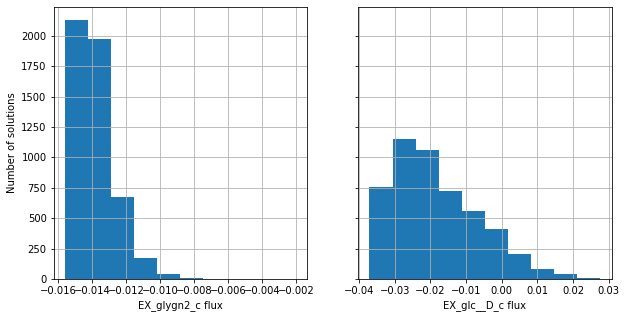

In [95]:
combined =trial.copy()
df = cobra.sampling.sample(combined, 5000, method = "optgp", processes = 5)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['EX_glygn2_c'].hist(ax=ax)
ax.set_xlabel('EX_glygn2_c flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['EX_glc__D_c'].hist(ax=ax)
ax.set_xlabel('EX_glc__D_c flux')

Text(0.5, 0, 'FBA flux')

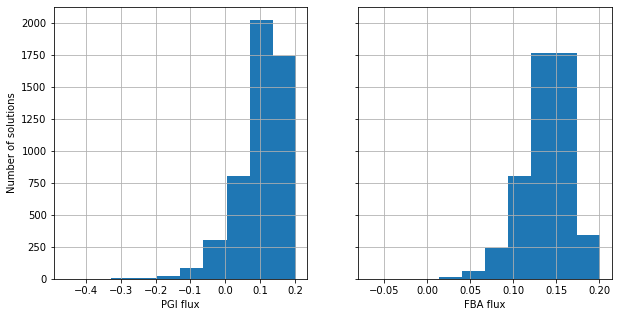

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['PGI'].hist(ax=ax)
ax.set_xlabel('PGI flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['FBA'].hist(ax=ax)
ax.set_xlabel('FBA flux')

In [97]:
# plt.hist(fva.loc["EX_glc__D_c"], 
#          alpha=0.25, # the transaparency parameter
#          label='state_1')

In [98]:
def plot_fva(atpm_values, max_pfk_values, max_fbp_values, min_pfk_values, min_fbp_values):
    """
    Parameters
    ----------
    atpm_values : list
        list of ATPM flux values from 0 to max
        
    max_g6pdh_values : list
        list of maximum G6PDH2r flux values at the ATPM fluxes in atpm_values
    max_pgi_values : list
        list of maximum PGI flux values at the ATPM fluxes in atpm_values

    min_g6pdh_values : list 
        list of minimum G6PDH2r flux values at the ATPM fluxes in atpm_values

    min_pgi_values : list
        list of minimum PGI flux values at the ATPM fluxes in atpm_values

    """
    plt.fill_between(atpm_values, max_pfk_values, min_pfk_values, 
                     label='Glcyogen', alpha=.7)
    plt.fill_between(atpm_values, max_fbp_values, min_fbp_values, 
                     label='Glucose', alpha=.7)
    plt.legend()
    plt.xlabel('Glucose and Glycogen flux')
    plt.ylabel('Range of possible fluxes')

In [99]:
trial.optimize()
print(trial.objective)

Minimize
-1.0*EX_glc__D_c + 1.0*EX_glc__D_c_reverse_5a3d5 + 1.0*EX_glygn2_c - 1.0*EX_glygn2_c_reverse_c774a


In [100]:
var_rxn = 'PGMT'
var_rxn_2 = 'PGI'
rxn = 'EX_glc__D_c'
trial.objective = rxn
obj = trial.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    trial.reactions.get_by_id(rxn).upper_bound = bound
    trial.reactions.get_by_id(rxn).lower_bound = bound


    trial.objective = var_rxn
    lower.append(trial.optimize('minimize').objective_value)
    upper.append(trial.optimize().objective_value)
    trial.objective = var_rxn_2
    upper_2.append(trial.optimize('minimize').objective_value)
    lower_2.append(trial.optimize().objective_value)
    
    trial.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

ValueError: The lower bound must be less than or equal to the upper bound (0 <= -0.0041613).

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpbv4p0yfr.lp
Reading time = 0.01 seconds
: 183 rows, 384 columns, 1448 nonzeros


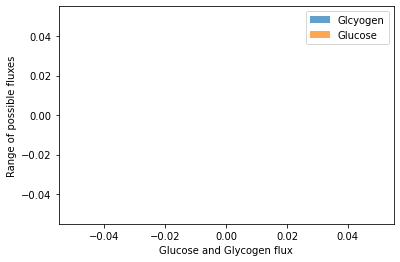

In [ ]:
combined = trial.copy()
rxn = 'ATPM'
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [ ]:
combined = trial.copy()
rxn = "EX_glc__D"
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [ ]:
combined = trial.copy()
rxn = "ATPM"
var_rxn = 'HEX1'
var_rxn_2 = 'G6PP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [ ]:
# dual_objective = trial.problem.Objective(
#     -trial.reactions.EX_glc__D_c.flux_expression-
#     trial.reactions.EX_glygn2_c.flux_expression,
#     direction='min')
# cobra.util.solver.fix_objective_as_constraint(trial)
# trial.objective = dual_objective

# flux_solution = trial.optimize(objective_sense='minimise')
# data_1 = cobra.sampling.sample(trial, 5000, method = "optgp", processes = 4)

In [ ]:
# dual_objective = trial.problem.Objective(
#     -trial.reactions.EX_glc__D_c.flux_expression-
#     trial.reactions.EX_glygn2_c.flux_expression,
#     direction='max')
# trial.objective = dual_objective
# cobra.util.solver.fix_objective_as_constraint(trial)
# flux_solution = trial.optimize(objective_sense='minimise')
# data_2 = cobra.sampling.sample(trial, 5000, method = "optgp", processes = 4)

In [ ]:
# dual_objective = trial.problem.Objective(
#     +trial.reactions.EX_glc__D_c.flux_expression-
#     trial.reactions.EX_glygn2_c.flux_expression,
#     direction='min')
# trial.objective = dual_objective
# cobra.util.solver.fix_objective_as_constraint(trial)
# flux_solution = trial.optimize(objective_sense='minimise')
# data_3 = cobra.sampling.sample(trial, 5000, method = "optgp", processes = 4)

In [ ]:
# dual_objective = trial.problem.Objective(
#     +trial.reactions.EX_glc__D_c.flux_expression-
#     trial.reactions.EX_glygn2_c.flux_expression,
#     direction='max')
# trial.objective = dual_objective
# cobra.util.solver.fix_objective_as_constraint(trial)
# flux_solution = trial.optimize(objective_sense='minimise')
# data_4 = cobra.sampling.sample(trial, 5000, method = "optgp", processes = 4)

In [ ]:
# mean_flux_1 = pd.DataFrame( columns =["reaction","mean", "stdev"])
# # means =[]
# # std=[]
# for i in data_1.columns:
#     mean = data_1[i].mean()
#     # print(index)
#     # means.append(index)
#     std = data_1[i].std()
#     mean_flux_1.loc[len(mean_flux_1.index)] = [i, mean, std]
# # mean_flux["Mean_gluco"] = means
# # mean_flux["ST_dev_gluco"] = std
# mean_flux = mean_flux_1.set_index("reaction")
# mean_flux

In [ ]:
# # importing libraries
# import matplotlib.pyplot as plt
# import seaborn as sns

In [ ]:
# plt.hist(data_1['PFK'], 
#          alpha=0.25, # the transaparency parameter
#          label='state_1_PFK')
# # plt.axvline(x_position)
  
# plt.hist(data_2['PFK'], 
#          alpha=0.25, # the transaparency parameter
#          label='state_2_PFK')

# plt.hist(data_3['PFK'], 
#          alpha=0.25, # the transaparency parameter
#          label='state_3_PFK')        

# plt.hist(data_4['PFK'], 
#          alpha=0.25, # the transaparency parameter
#          label='state_4_PFK')        
  
# plt.legend(loc='upper right')
# plt.title('Overlapping with both alpha=0.5')
# plt.show()

In [ ]:
# list_rxn =['PGMT', 'ENO', "FBA", "HEX1", "EX_glc__D_c", "EX_glygn2_c"]
# #  GAPDH, ENO, FBA, PGI, PGMT
# for i in list_rxn:
#     plt.hist(data_1[i], 
#          alpha=0.25, # the transaparency parameter
#          label='state_1')
# #     x_position = mean_flux.loc[i, "mean"]
  
#     plt.hist(data_2[i], 
#             alpha=0.25, # the transaparency parameter
#             label='state_2')
#     x_position = mean_flux.loc[i, "mean"]

#     plt.hist(data_3[i], 
#             alpha=0.25, # the transaparency parameter
#             label='state_3')     
#     x_position = mean_flux.loc[i, "mean"]

#     plt.hist(data_4[i], 
#             alpha=0.25, # the transaparency parameter
#             label='state_4')        
    
#     plt.legend(loc='upper right')
#     plt.title('Overlapping histograms of '+str(i))
#     plt.show()

In [ ]:
from copy import deepcopy

In [ ]:
combined_1 =trial.copy()
dual_objective = combined_1.problem.Objective(
    -combined_1.reactions.EX_glc__D_c.flux_expression-
    combined_1.reactions.EX_glygn2_c.flux_expression,
    # direction='min'
    )

combined_1.objective = dual_objective
flux_solution = trial.optimize(objective_sense='minimise')
# combined.solver.update()

cobra.util.solver.fix_objective_as_constraint(combined_1)
# constraint = combined.problem.Constraint(-
#     trial.reactions.EX_glc__D_c.flux_expression 
#     # - trial.reactions.EX_glygn2_c.flux_expression,
#     lb=-20,
#     ub=20)
# combined.add_cons_vars(constraint)
# # combined.solver.update()

# for i in combined_1.constraints:
#     print(i)

In [ ]:
combined_1 =trial.copy()
dual_objective = combined_1.problem.Objective(
    -combined_1.reactions.EX_glc__D_c.flux_expression-
    combined_1.reactions.EX_glygn2_c.flux_expression,
    # direction='min'
    )

combined_1.objective = dual_objective
flux_solution = trial.optimize(objective_sense='minimise')
# combined.solver.update()

cobra.util.solver.fix_objective_as_constraint(combined_1)
# constraint = combined.problem.Constraint(-
#     trial.reactions.EX_glc__D_c.flux_expression 
#     # - trial.reactions.EX_glygn2_c.flux_expression,
#     lb=-20,
#     ub=20)
# combined.add_cons_vars(constraint)
# # combined.solver.update()

# for i in combined_1.constraints:
#     print(i)

In [ ]:
data_1 = pd.DataFrame(cobra.sampling.sample(combined_1, 5000, method = "optgp", processes = 4))
data_1.head(20)

In [ ]:
data_2.head(20)
data_2.EX_glc__D_c

In [ ]:
combined_2 =trial.copy()
dual_objective = combined_2.problem.Objective(
    -combined_2.reactions.EX_glc__D_c.flux_expression+
    combined_2.reactions.EX_glygn2_c.flux_expression,
    # direction='max'
    )
combined_2.objective = dual_objective
flux_solution = trial.optimize(objective_sense='minimise')
cobra.util.solver.fix_objective_as_constraint(combined_2)
# flux_solution = combined.optimize()
# co = combined.problem.Constraint(combined.reactions.EX_glc__D.flux_expression, lb=0)
# combined.add_cons_vars([co])


data_2 = cobra.sampling.sample(combined_2, 5000, method = "optgp", processes = 4)

In [ ]:
combined_3 =trial.copy()
dual_objective = combined_3.problem.Objective(
    +combined_3.reactions.EX_glc__D_c.flux_expression-
    combined_3.reactions.EX_glygn2_c.flux_expression,
    # direction='min'
    )
combined_3.objective = dual_objective
flux_solution = trial.optimize(objective_sense='minimise')
cobra.util.solver.fix_objective_as_constraint(combined_3)
# flux_solution = combined.optimize()
# co = combined.problem.Constraint(combined.reactions.EX_glc__D.flux_expression, lb=0)
# combined.add_cons_vars([co])


data_3 = cobra.sampling.sample(combined_3, 5000, method = "optgp", processes = 4)


In [ ]:
combined_4 =trial.copy()
dual_objective = combined_4.problem.Objective(
    +combined_4.reactions.EX_glc__D_c.flux_expression+
    combined_4.reactions.EX_glygn2_c.flux_expression,
    # direction='max'
    )
combined_4.objective = dual_objective
flux_solution = trial.optimize(objective_sense='minimise')
cobra.util.solver.fix_objective_as_constraint(combined_4) 
# flux_solution = combined.optimize()
# co = combined.problem.Constraint(combined.reactions.EX_glc__D.flux_expression, lb=0)
# combined.add_cons_vars([co])


data_4 = cobra.sampling.sample(combined_4, 5000, method = "optgp", processes = 4)


In [ ]:
# for i in combined_2.constraints:
#     print(i)

# for i in combined_4.constraints:
#     print(i)

In [ ]:
# df
mean_flux_1 = pd.DataFrame( columns =["reaction","mean", "stdev"])
# means =[]
# std=[]
for i in data_1.columns:
    mean = data_1[i].mean()
    # print(index)
    # means.append(index)
    std = data_1[i].std()
    mean_flux_1.loc[len(mean_flux_1.index)] = [i, mean, std]
# mean_flux["Mean_gluco"] = means
# mean_flux["ST_dev_gluco"] = std
mean_flux = mean_flux_1.set_index("reaction")
mean_flux.loc["EX_glc__D_c"]

In [ ]:
data_2.head(20)

In [ ]:
linear_reaction_coefficients(combined_1)

In [ ]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_1.head(20)

In [ ]:
plt.hist(data_1['PFK'], 
         alpha=0.25, # the transaparency parameter
         label='state_1_PFK')
# plt.axvline(x_position)
  
plt.hist(data_2['PFK'], 
         alpha=0.25, # the transaparency parameter
         label='state_2_PFK')

plt.hist(data_3['PFK'], 
         alpha=0.25, # the transaparency parameter
         label='state_3_PFK')        

plt.hist(data_4['PFK'], 
         alpha=0.25, # the transaparency parameter
         label='state_4_PFK')        
  
plt.legend(loc='upper right')
plt.title('Overlapping with both alpha=0.5')
plt.show()

the flux states of PGI looks weird cuz it's supposed to be positive and negative

In [ ]:
list_rxn =['PGMT', 'ENO', "FBA", "HEX1", "EX_glc__D_c", "EX_glygn2_c"]
#  GAPDH, ENO, FBA, PGI, PGMT
for i in list_rxn:
    plt.hist(data_1[i], 
         alpha=0.25, # the transaparency parameter
         label='state_1')
#     x_position = mean_flux.loc[i, "mean"]
  
    plt.hist(data_2[i], 
            alpha=0.25, # the transaparency parameter
            label='state_2')
#     x_position = mean_flux.loc[i, "mean"]

    plt.hist(data_3[i], 
            alpha=0.25, # the transaparency parameter
            label='state_3')     
#     x_position = mean_flux.loc[i, "mean"]

    plt.hist(data_4[i], 
            alpha=0.25, # the transaparency parameter
            label='state_4')        
    
    plt.legend(loc='upper right')
    plt.title('Overlapping histograms of '+str(i))
    plt.show()

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# ax = axes[0]
# df['GLGNS1'].hist(ax=ax)
# ax.set_xlabel('GLGNS1 flux')
# ax.set_ylabel('Number of solutions')

# ax = axes[1]
# ax = df['GLPASE1'].hist(ax=ax)
# ax.set_xlabel('GLPASE1 flux')

In [ ]:
# # df
# mean_flux = pd.DataFrame( columns =["reaction","mean", "stdev"])
# # means =[]
# # std=[]
# for i in df.columns:
#     mean = df[i].mean()
#     # print(index)
#     # means.append(index)
#     std = df[i].std()
#     mean_flux.loc[len(mean_flux.index)] = [i, mean, std]
# # mean_flux["Mean_gluco"] = means
# # mean_flux["ST_dev_gluco"] = std
# mean_flux

In [ ]:
from tqdm import tqdm
from scipy.integrate import solve_ivp

# dFBA analysis

In [ ]:
def add_dynamic_bounds(trial, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    atpm, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    trial.reactions.EX_glc__D_c.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    atpm, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with trial:
        add_dynamic_bounds(trial, y)

        cobra.util.add_lp_feasibility(trial)
        feasibility = cobra.util.fix_objective_as_constraint(trial)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            trial, ['EX_glygn2_c', 'EX_glc__D_c'], ['max', 'max'])
# try max and mim 
    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    # fluxes *= atpm

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with trial:

        add_dynamic_bounds(trial, y)

        cobra.util.add_lp_feasibility(trial)
        feasibility = cobra.util.fix_objective_as_constraint(trial)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [ ]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Glycogen', color='b')
ax2.set_ylabel('Glucose', color='r')

### Making Df of metabolites and reactions, exporting them, and importing to form MASS model

In [ ]:
# etc= [
#     'FADH2ETC',
#     'NADH2_u10mi',
#     'CYOR_u10mi',
#     'CYOOm2i',
#     'MALtm',
#     'AKGMALtm',
#     'MDH',
#     'ASPTA',
#     'ASPGLUm',
#     'ASPTAm',

# ] 

# reaction_list = ['HEX1',
#                 'PGI',
#                 'FBP',
#                 'PFK',
#                 'FBA',
#                 'TPI',
#                 'GAPD',
#                 'PGK',
#                 'PGM',
#                 'ENO',
#                 # 'PEPtm',
#                 'PEPCKm',
#                 'PYK',
#                 'PCm',
#                 'LDH_L',
                
#                 'PGMT',
#                 "GLPASE2",
#                 'GLDBRAN',
#                 'GLBRAN',
#                 "GLPASE1",
#                 'GLGNS1',
#                 'GGNG',
#                 'GALUi',
#                 # 'CO2tm',
#                 # 'Htm',
#                 # 'O2tm',
#                 #  'H2Otm',
                 
# #                 'G6Pter',
# #                 'G6PPer',
# #                 'GLCter',
# #                 'GLCt1',
#                 # 'PYRt2m', 
# #                 'H2Oter', 
# #                 'PIter', 
# #                 'H2Ot', 
# #                 'PIt', 
# #                 'Ht', 
# #                 'L_LACt2r', #lactose transport between lactate in cytosol and extracellular 
# #                  'PYRt2',
#                 'ADK1',
#                 'ATPM',
# #                 'DM_nadh'
#                 ]

In [ ]:
# from cobra_dict import metabolite_to_dict as metabolite_to_dict
# from cobra_dict import reaction_to_dict as reaction_to_dict

In [ ]:
# met_df=pd.DataFrame()
# for met in trial.metabolites:
#     cobra_met= trial.metabolites.get_by_id(met.id)
#     m=metabolite_to_dict(cobra_met)
#     df_2=pd.DataFrame.from_dict(m,orient='index')
#     df_2=df_2.T
#     met_df=pd.concat([met_df, df_2])
# met_df=met_df.set_index('id')
# met_df

In [ ]:
# csv_met_cobra = os.path.join(data_dir,"core_cobra_met.csv")
# met_df.to_csv(csv_met_cobra)

In [ ]:
# rxn_df=pd.DataFrame()
# for rxn in trial.reactions:
#     cobra_rxn= trial.reactions.get_by_id(rxn.id)
#     r=reaction_to_dict(cobra_rxn)
# #     print(r)
#     df=pd.DataFrame.from_dict(r,orient='index')
#     df=df.T
#     rxn_df= pd.concat([rxn_df, df])
# rxn_df=rxn_df.set_index('id')
# # rxn_df

In [ ]:
# json_rxn_cobra = os.path.join(data_dir,"core_cobra_rxn.json")
# rxn_df.to_json(json_rxn_cobra,orient="index")

## Making MASS model of glycolysis

In [ ]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [ ]:
csv_met = os.path.join(data_dir,"small_core_met_df.csv")
json_rxn = os.path.join(data_dir,"small_core_reaction_df.json")

In [ ]:
# making dataframe of metabolites
import json
met_csv_df = pd.read_csv(csv_met,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn) as json_file:
    mass_rxn_data = json.load(json_file)

In [ ]:
mass_metabolite_info

In [ ]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    # print(met.compartment)
    liver.add_metabolites(met)

In [ ]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

In [ ]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)

In [ ]:
from mass.io import json, sbml

In [ ]:
model_dir

In [ ]:
mass_small_core = os.path.join(model_dir,"Mass_small_core_model.json")
json.save_json_model(mass_model=liver, filename=mass_small_core)

## Setting initial conditions

In [ ]:
pd.DataFrame(
    ppp.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids,
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"]).T



In [ ]:
import csv
import openpyxl

In [ ]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [ ]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations2.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all

In [ ]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

In [ ]:
# new_index= []
# for i in conc_df.index:
#     base = conc_df.index.get_loc(i)
#     # print(base)
#     # l = len(i)
#     # new = i[:l-2]
#     # new_index.append(new)
#     # print(new)
#     # conc_df.index.get_loc(base) = new
#     # new_id = i.rpartition("_" + str(met.compartment))[0]

# conc_df= conc_df.reset_index(drop=True)
# conc_df["ID"] = new_index
# conc_df.set_index('ID',drop=True,inplace=True)
# conc_df

In [ ]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            # print(ic_value)
            # row = [mid,ic_value]
            # column = [ic_value]
            # conc_df.append(row)
            met.ic =  ic_value    
                    
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

In [ ]:
for i in liver.metabolites:
    print(i.compartment)

### Getting Standard and Physiological Gibbs energies of reactions to get Keq of reactions

In [ ]:
met_list = []
liver.boundary_conditions
for reaction in liver.boundary_conditions:
    print(reaction)

In [ ]:
excluded_reactions=["ATPM", "NADHM","PYRt2m","PEPtm"]


In [ ]:
for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    print(reaction,reaction.Keq)

In [ ]:
for i in liver.metabolites:
    print(i,i.compartment)
    # i.compartment = "cytosol"

In [ ]:
# occoa_prod_c nan
# octa_prod_c nan
# glyc3p_1octa_c nan
# glyc3p_2octa_c nan
# glyc_2octa_c nan
# glyc_3octa_c nan
# ACP_c nan
# malACP_c nan
# acACP_c nan
# actACP_c nan
# 3haACP_c nan
# but2eACP_c nan
# butACP_c nan
# 3ohexACP_c nan
# 3hhexACP_c nan
# thex2eACP_c nan
# hexACP_c nan
# 3ooctACP_c nan
# 3hoctACP_c nan
# toct2eACP_c nan
# oc2coa_m nan
# 3hocoa_m nan
# 3oocoa_m nan
# hxcoa_m m
# hx2coa_m m
# 3hhcoa_m nan
# 3ohcoa_m nan
# btcoa_m m
# b2coa_m m
# 3hbcoa_m m
# octa_cons_c nan


In [ ]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

In [ ]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")


cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import *
Keq_df=pd.DataFrame(columns=["Reaction","Keq"])
# Keq_df

In [ ]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id
            new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id
            new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        # print(reaction_to_parse)
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        # df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        # Keq_df.append(df)

# Keq_df    

In [ ]:
from mass.util.matrix import left_nullspace, matrix_rank

In [ ]:
print(liver.S.shape)
print(matrix_rank(liver.S))



In [ ]:
# liver.reactions.NADHM.Keq=1e6
liver.reactions.ATPM.Keq=1e6
liver.reactions.PEPtm.Keq=1
liver.reactions.PYRt2m.Keq=1

In [ ]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

##  Set Fluxes

In [ ]:
fluxes_mass = flux_solution.to_frame()
fluxes_mass = fluxes_mass

In [ ]:
no_flux =[]
for r in liver.reactions:
    if r.id in fluxes_mass.index:
        row =  fluxes_mass.loc[r.id,"fluxes"]
        print(r.id, row)
    else:
        no_flux.append(r.id)

no_flux

In [ ]:
reaction_list=[]
for reaction in liver.reactions:
    reaction_list.append(reaction.id)


In [ ]:
# for reaction, flux in fluxes_mean.itertuples():
#     # print(flux)
#     reaction = liver.reactions.get_by_id(reaction)
#     reaction.steady_state_flux = flux * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
#     print("{0}: {1}".format(reaction.flux_symbol_str,
#                             reaction.steady_state_flux))

## Set H2O/H Constants

In [ ]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
"h_c",'h_i', 'h_m', 
    
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",'h2o_m', 
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c', 'pi_m']:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [ ]:
for metabolite in [
'h_i', 'h_m',
"h_c", 
#     'h_e',
"h2o_c",'h2o_m'
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [ ]:
seed = int(4)
n_models = 5000

In [ ]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
    'h_i', 'h_m',
    # 'o2_m', 'o2_c', 
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",'h2o_m',
        
#     "pi_e",
    # "glc__D_e",
#  "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        
# 'NADPHM',
 "PYRt2m","PEPtm", 'Htmi','MALtm', 'ATPtm', 'AKGMALtm','O2tm','H2Otm',  'CO2tm', 'PItm' ,'Htm'
        
        
    #     "Ht", "H2Ot", "H2Oter",'PIter','PIt',
    # 'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

In [ ]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(liver.fixed),
    fixed_Keq_bounds=liver.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = liver.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models,  processes=4, seed=seed)
conc_samples.head()


In [ ]:
type(conc_samples)

In [ ]:
mean_conc = pd.DataFrame(index = conc_samples.columns)
means =[]
std=[]
for i in conc_samples.columns:
    index = conc_samples[i].mean()
    # print(index)
    means.append(index)
    std.append(conc_samples[i].std())
mean_conc["Mean"] = means
mean_conc["ST_dev"] = std
mean_conc

In [ ]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in mean_conc.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = mean_conc.loc[mid,'Mean']
            row = [mid,ic_value]
            # column = [ic_value]
            # conc_df.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

In [ ]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [ ]:
Boundary= [
    "ATPM",
    
#     'EX_nad_c',
    # "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h",'h2o',
    
#         'h_e',
#  'h_m',
#     'h2o_r','h2o_e',
        'pi',
    # 'pi_c',
#     "pi_e",
"glc__D",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        # "Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1',
'PYRt2m','PEPtm',
'NADHM','ATPM',
'CO2tm', 'ATPtm', 'Htm','PIt2m'
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

In [ ]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog", 
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True)

In [ ]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
                       )
}, update_reactions=True)
# print(percs)                      

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
conc_solution.concentrations

In [ ]:
liver.boundary_conditions['co2_b']=0.657953 ##M
liver.boundary_conditions['gdp_b']=0.657953 ##M
liver.boundary_conditions['gtp_b']=1.519864 ##M
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=1 ##M
liver.boundary_conditions['hco3_b']=0.001827 ##M

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
model_json = os.path.join(model_dir,"Gly_Gluco_no_cmpt.json")
json.save_json_model(mass_model=liver, filename=model_json)